In [1]:
import os
os.chdir("/Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter")  # <-- your project root


In [2]:
import os, sys, pathlib, subprocess, shlex, importlib

PROJECT = "/Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter"
os.chdir(PROJECT)
print("CWD:", os.getcwd())

# 1) Montre-moi quel Python utilise le noyau du notebook
print("Notebook Python:", sys.executable)

# 2) Installe feedparser AVEC le Python du noyau du notebook
subprocess.run([sys.executable, "-m", "pip", "install", "--quiet", "feedparser"], check=True)

# 3) Vérifie l'import + version
fp = importlib.import_module("feedparser")
print("feedparser version:", getattr(fp, "__version__", "unknown"))

# 4) Prépare PYTHONPATH pour voir scripts/ et src/
root = str(pathlib.Path(".").resolve())
src  = str(pathlib.Path("src").resolve())
env = os.environ.copy()
env["PYTHONPATH"] = os.pathsep.join([root, src, env.get("PYTHONPATH","")])
print("PYTHONPATH:", env["PYTHONPATH"])

START = "2018-01-02"
END   = "2025-11-25"
TICKS = "AAPL, MSFT, TSLA, AMZN, GOOGL, META, NVDA, AMD, INTC, QCOM, NFLX, SHOP, CRM, ORCL, JPM, BAC, GS, MS, MA, V, XOM, CVX, BP, PFE, MRK, UNH, DIS, NKE, BA, CAT, COST, WMT, TGT, KO, PEP, IBM, UPS, SPY, QQQ, DIA"

cmd_list = [
    sys.executable, "-m", "scripts.fetch_headlines",
    "--config", "configs/default.yaml",
    "--start", START,
    "--end", END,
    "--tickers", TICKS,
    "--out", "data/raw/news/headlines.csv",
]
subprocess.run(cmd_list, check=True, env=env, cwd=PROJECT)

import pandas as pd
df = pd.read_csv("data/raw/news/headlines.csv")
print(len(df), "rows")
df.tail()


CWD: /Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter
Notebook Python: /Users/rosaliemassein/opt/anaconda3/envs/cs229/bin/python
feedparser version: 6.0.12
PYTHONPATH: /Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter:/Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter/src:
[info] AAPL: kept 33 items in [2018-01-02 → 2025-11-25]
[info] MSFT: kept 60 items in [2018-01-02 → 2025-11-25]
[info] TSLA: kept 89 items in [2018-01-02 → 2025-11-25]
[info] AMZN: kept 39 items in [2018-01-02 → 2025-11-25]
[info] GOOGL: kept 43 items in [2018-01-02 → 2025-11-25]
[info] META: kept 96 items in [2018-01-02 → 2025-11-25]
[info] NVDA: kept 49 items in [2018-01-02 → 2025-11-25]
[info] AMD: kept 74 items in [2018-01-02 → 2025-11-25]
[info] INTC: kept 99 items in [2018-01-02 → 2025-11-25]


,date,ticker,text,source,url,published_at
1696,2025-11-24,XOM,Weik Capital Management Raises Stock Position ...,MarketBeat,https://news.google.com/rss/articles/CBMi0wFBV...,2025-11-24T13:55:48+00:00
1697,2025-11-24,XOM,Insigneo Advisory Services LLC Increases Holdi...,MarketBeat,https://news.google.com/rss/articles/CBMi2AFBV...,2025-11-24T12:53:36+00:00
1698,2025-11-24,XOM,"Intellus Advisors LLC Sells 14,504 Shares of E...",MarketBeat,https://news.google.com/rss/articles/CBMizAFBV...,2025-11-24T12:07:27+00:00
1699,2025-11-24,XOM,Exxon Mobil Corporation $XOM Shares Sold by Ed...,MarketBeat,https://news.google.com/rss/articles/CBMivgFBV...,2025-11-24T10:08:26+00:00
1700,2025-11-24,XOM,Fiducient Advisors LLC Has $3.45 Million Stake...,MarketBeat,https://news.google.com/rss/articles/CBMi0gFBV...,2025-11-24T09:56:10+00:00


In [3]:
import os, sys, math, shutil
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# --- 1) Clean up environment that breaks huggingface_hub ---
for k in ("HF_HUB_HEADERS", "HUGGINGFACE_HUB_HEADERS"):
    if k in os.environ:
        os.environ.pop(k)

os.environ.setdefault("HF_HUB_DISABLE_TELEMETRY", "1")
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

# Optional: if a local folder named 'ProsusAI/finbert' shadows the remote repo, remove it
local_shadow = Path("ProsusAI/finbert")
if local_shadow.exists() and local_shadow.is_dir():
    shutil.rmtree(local_shadow)

# --- 2) Imports (after env cleanup) ---
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

# Known-good versions you used earlier (make sure these are already installed in .uv-venv):
# torch==2.1.2, transformers==4.44.2, huggingface_hub==0.24.6, numpy==1.26.4, pandas, tqdm

# --- 3) Load FinBERT pipeline ---
model_id = "ProsusAI/finbert"
tok = AutoTokenizer.from_pretrained(model_id)
mdl = AutoModelForSequenceClassification.from_pretrained(model_id, use_safetensors=True)
pipe = TextClassificationPipeline(model=mdl, tokenizer=tok, top_k=None)  # returns all labels with probabilities

print("✅ FinBERT loaded and ready")

# --- 4) IO paths ---
inp  = Path("data/raw/news/headlines.csv")
out_triplet = Path("data/processed/sent_headlines_triplet.csv")
out_score   = Path("data/processed/sent_headlines_score.csv")
out_triplet.parent.mkdir(parents=True, exist_ok=True)

# --- 5) Load headlines ---
df = pd.read_csv(inp)
# Expect at least columns: ['date','ticker','text'] (your notebook used that)
required_cols = {"date","ticker","text"}
missing = required_cols - set(map(str.lower, df.columns))
# Robust remap to lower in case of capitalization
df.columns = [c.lower() for c in df.columns]
if not required_cols.issubset(df.columns):
    raise ValueError(f"Missing required columns {required_cols - set(df.columns)} in {inp}")

# --- 6) Run FinBERT in batches and collect outputs ---
def run_batch(texts):
    # pipe returns list of list-of-dicts, one list per input
    # each inner list has dicts like {'label':'positive','score':0.73}, etc.
    res = pipe(texts)
    triplets = []
    for one in res:  # one = list for a single text
        probs = {"positive":0.0, "neutral":0.0, "negative":0.0}
        for d in one:
            probs[d["label"].lower()] = float(d["score"])
        p_pos = probs["positive"]
        p_neu = probs["neutral"]
        p_neg = probs["negative"]
        triplets.append((p_pos, p_neu, p_neg, p_pos - p_neg))
    return triplets

BATCH = 64
rows = []
for i in tqdm(range(0, len(df), BATCH), desc="FinBERT"):
    batch = df.iloc[i:i+BATCH]
    out = run_batch(batch["text"].tolist())
    for (p_pos, p_neu, p_neg, score), (_, row) in zip(out, batch.iterrows()):
        rows.append({
            "date":  row["date"],
            "ticker":row["ticker"],
            "p_pos": p_pos,
            "p_neu": p_neu,
            "p_neg": p_neg,
            "sent_score": score
        })

sent = pd.DataFrame(rows)

# --- 7) Save triplet + score as requested ---
sent[["date","ticker","p_pos","p_neu","p_neg"]].to_csv(out_triplet, index=False)
sent[["date","ticker","sent_score"]].to_csv(out_score, index=False)

print(f"[ok] wrote {out_triplet} | rows={len(sent)} cols=5")
print(f"[ok] wrote {out_score}   | rows={len(sent)} cols=3")

/Users/rosaliemassein/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


✅ FinBERT loaded and ready


FinBERT: 100%|██████████████████████████████████| 27/27 [00:26<00:00,  1.00it/s]

[ok] wrote data/processed/sent_headlines_triplet.csv | rows=1701 cols=5
[ok] wrote data/processed/sent_headlines_score.csv   | rows=1701 cols=3


In [4]:
import pandas as pd

# Load sentiment score
score = pd.read_csv("data/processed/sent_headlines_score.csv", parse_dates=["date"])
triplet = pd.read_csv("data/processed/sent_headlines_triplet.csv", parse_dates=["date"])

score["ticker"] = score["ticker"].astype(str).str.upper()
triplet["ticker"] = triplet["ticker"].astype(str).str.upper()

# Aggregate
sent_base = (
    score.groupby(["ticker", "date"], as_index=False)
         .agg(sent_score=("sent_score", "mean"), 
              news_count=("sent_score", "count"))
    .merge(
        triplet.groupby(["ticker","date"], as_index=False)
               .agg(p_pos=("p_pos","mean"),
                    p_neu=("p_neu","mean"),
                    p_neg=("p_neg","mean")),
        on=["ticker","date"],
        how="left"
    )
)

print("Base sentiment features:", sent_base.shape)
sent_base.head()


Base sentiment features: (620, 7)


,ticker,date,sent_score,news_count,p_pos,p_neu,p_neg
0,AAPL,2025-11-14,-0.114580,1,0.026177,0.833066,0.140757
1,AAPL,2025-11-16,0.059030,1,0.083194,0.892642,0.024163
2,AAPL,2025-11-20,0.151751,2,0.161480,0.828792,0.009729
3,AAPL,2025-11-21,-0.008434,5,0.099808,0.791950,0.108242
4,AAPL,2025-11-22,-0.143950,6,0.054260,0.747530,0.198210


In [5]:
import pandas as pd
import numpy as np

def compute_sentiment_features(df, windows=(3, 5, 10), vol_window=10):
    """
    Compute technical-style features for sentiment data.
    
    Args:
        df: DataFrame with columns: date, ticker, and sentiment columns (e.g., sent_score, p_pos, p_neu, p_neg)
        windows: tuple of window sizes for moving averages
        vol_window: window for volatility calculation
    
    Returns:
        DataFrame with original columns plus sentiment technical features
    """
    out = df.sort_values(['ticker', 'date']).copy()
    
    # Identify sentiment columns
    sent_cols = [c for c in df.columns if c in ['sent_score', 'p_pos', 'p_neu', 'p_neg'] or 
                 c.startswith(('sent_', 'p_pos', 'p_neu', 'p_neg'))]
    
    if not sent_cols:
        print("[warn] No sentiment columns found")
        return out
    
    # For each sentiment column, compute features
    for sent_col in sent_cols:
        if sent_col not in out.columns:
            continue
            
        # Group by ticker for time series operations
        grouped = out.groupby('ticker')[sent_col]
        
        # === 1. Moving Averages (SMA & EMA) ===
        for w in windows:
            # Simple Moving Average
            out[f'{sent_col}_sma_{w}'] = grouped.transform(lambda x: x.rolling(w, min_periods=1).mean())
            
            # Exponential Moving Average
            out[f'{sent_col}_ema_{w}'] = grouped.transform(lambda x: x.ewm(span=w, adjust=False).mean())
            
            # Distance from moving average (normalized)
            out[f'{sent_col}_dist_sma_{w}'] = out[sent_col] - out[f'{sent_col}_sma_{w}']
            out[f'{sent_col}_dist_ema_{w}'] = out[sent_col] - out[f'{sent_col}_ema_{w}']
        
        # === 2. Momentum & Rate of Change ===
        for w in windows:
            # Simple momentum (difference)
            out[f'{sent_col}_mom_{w}'] = grouped.transform(lambda x: x.diff(w))
            
            # Rate of change (percentage-like for sentiment)
            out[f'{sent_col}_roc_{w}'] = grouped.transform(
                lambda x: x.diff(w) / (x.shift(w).abs() + 0.1)  # Add small constant to avoid div by zero
            )
        
        # === 3. Volatility & Standard Deviation ===
        # Rolling standard deviation
        out[f'{sent_col}_std_{vol_window}'] = grouped.transform(
            lambda x: x.rolling(vol_window, min_periods=2).std()
        )
        
        # Coefficient of variation (normalized volatility)
        out[f'{sent_col}_cv_{vol_window}'] = out[f'{sent_col}_std_{vol_window}'] / (
            out[f'{sent_col}_sma_{vol_window}'].abs() + 0.1
        )
        
        # === 4. Min/Max over windows ===
        for w in [5, 10]:
            out[f'{sent_col}_max_{w}'] = grouped.transform(lambda x: x.rolling(w, min_periods=1).max())
            out[f'{sent_col}_min_{w}'] = grouped.transform(lambda x: x.rolling(w, min_periods=1).min())
            
            # Position within range (0 = at min, 1 = at max)
            range_val = out[f'{sent_col}_max_{w}'] - out[f'{sent_col}_min_{w}']
            out[f'{sent_col}_position_{w}'] = (
                (out[sent_col] - out[f'{sent_col}_min_{w}']) / (range_val + 1e-6)
            )
        
        # === 5. Trend Indicators ===
        # Simple linear trend (slope over window)
        for w in [5, 10]:
            out[f'{sent_col}_trend_{w}'] = grouped.transform(
                lambda x: x.rolling(w, min_periods=2).apply(
                    lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) > 1 else 0,
                    raw=True
                )
            )
        
        # === 6. Cumulative metrics ===
        # Cumulative sum (overall sentiment accumulation)
        out[f'{sent_col}_cumsum'] = grouped.transform('cumsum')
        
        # Exponentially weighted cumulative sum
        out[f'{sent_col}_ewm_cumsum'] = grouped.transform(
            lambda x: x.ewm(span=20, adjust=False).mean() * len(x)
        )
    
    # === 7. Cross-sentiment features (if we have triplet) ===
    if {'p_pos', 'p_neu', 'p_neg'}.issubset(out.columns):
        # Sentiment polarity (pos - neg)
        if 'sent_score' not in out.columns:
            out['sent_score'] = out['p_pos'] - out['p_neg']
        
        # Sentiment strength (total non-neutral)
        out['sent_strength'] = out['p_pos'] + out['p_neg']
        
        # Sentiment ratio (pos/neg ratio)
        out['sent_ratio'] = out['p_pos'] / (out['p_neg'] + 0.01)
        
        # Uncertainty (neutral proportion)
        out['sent_uncertainty'] = out['p_neu']
        
        # Dominant sentiment (which is highest)
        out['sent_dominant'] = out[['p_pos', 'p_neu', 'p_neg']].idxmax(axis=1).map({
            'p_pos': 1, 'p_neu': 0, 'p_neg': -1
        })
        
        # Sentiment consistency (std across triplet)
        out['sent_consistency'] = out[['p_pos', 'p_neu', 'p_neg']].std(axis=1)
    
    # === 8. News volume features (count of articles) ===
    # This would need the raw data before aggregation, but we can approximate
    # by tracking how sentiment volatility changes (proxy for article count)
    
    return out


def add_news_count_features(headlines_df, windows=(3, 5, 10)):
    """
    Add features based on news article counts per day.
    
    Args:
        headlines_df: Raw headlines with columns: date, ticker, text
        windows: Window sizes for moving averages
    
    Returns:
        DataFrame with date, ticker, and news count features
    """
    # Count articles per day per ticker
    counts = headlines_df.groupby(['date', 'ticker']).size().reset_index(name='news_count')
    counts = counts.sort_values(['ticker', 'date'])
    
    grouped = counts.groupby('ticker')['news_count']
    
    # Moving averages of news count
    for w in windows:
        counts[f'news_count_ma_{w}'] = grouped.transform(lambda x: x.rolling(w, min_periods=1).mean())
        counts[f'news_count_std_{w}'] = grouped.transform(lambda x: x.rolling(w, min_periods=2).std())
    
    # News surge indicator (current vs average)
    counts['news_surge_5'] = counts['news_count'] / (counts['news_count_ma_5'] + 0.5)
    counts['news_surge_10'] = counts['news_count'] / (counts['news_count_ma_10'] + 0.5)
    
    # Cumulative news count
    counts['news_cumcount'] = grouped.transform('cumsum')
    
    # Days since last news
    counts['days_since_news'] = grouped.transform(
        lambda x: x.eq(0).cumsum() - x.eq(0).cumsum().where(x.ne(0)).ffill().fillna(0)
    ).astype(int)
    
    return counts





In [6]:
sent_enhanced = compute_sentiment_features(sent_base)
print("Enhanced sentiment:", sent_enhanced.shape)


Enhanced sentiment: (620, 132)


/var/folders/b_/mlsl2ls12tv6tnhpgltb9vnc0000gn/T/ipykernel_19683/467595299.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f'{sent_col}_dist_sma_{w}'] = out[sent_col] - out[f'{sent_col}_sma_{w}']
/var/folders/b_/mlsl2ls12tv6tnhpgltb9vnc0000gn/T/ipykernel_19683/467595299.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f'{sent_col}_dist_ema_{w}'] = out[sent_col] - out[f'{sent_col}_ema_{w}']
/var/folders/b_/mlsl2ls12tv6tnhpgltb9vnc0000gn/T/ipykernel_19683/467595299.py:37: PerformanceWarning: DataFrame is highly fr

In [7]:
out_path = "data/processed/sentiment_features_enhanced.csv"
sent_enhanced.to_csv(out_path, index=False)
print("Saved to:", out_path)


Saved to: data/processed/sentiment_features_enhanced.csv


# Recreate technical features


In [8]:
PROJECT = "/Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter"
os.chdir(PROJECT)

# make project + src importable
root = str(pathlib.Path(".").resolve())
src  = str(pathlib.Path("src").resolve())
for p in [root, src]:
    if p not in sys.path:
        sys.path.insert(0, p)

from scripts.fetch_ohlcv import main as fetch_main
fetch_main("configs/default.yaml")   # uses your new tickers + date range

# quick check
import glob, pandas as pd
paths = sorted(glob.glob("data/raw/ohlcv_*.csv"))
print("OHLCV files found:", len(paths))


[info] Fetching OHLCV for: ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOGL', 'META', 'NVDA', 'AMD', 'INTC', 'QCOM', 'NFLX', 'SHOP', 'CRM', 'ORCL', 'JPM', 'BAC', 'GS', 'MS', 'MA', 'V', 'XOM', 'CVX', 'BP', 'PFE', 'MRK', 'UNH', 'DIS', 'NKE', 'BA', 'CAT', 'COST', 'WMT', 'TGT', 'KO', 'PEP', 'IBM', 'UPS', 'SPY', 'QQQ', 'DIA']
Saved data/raw/ohlcv_AAPL.csv (1986 rows)
Saved data/raw/ohlcv_MSFT.csv (1986 rows)
Saved data/raw/ohlcv_TSLA.csv (1986 rows)
Saved data/raw/ohlcv_AMZN.csv (1986 rows)
Saved data/raw/ohlcv_GOOGL.csv (1986 rows)
Saved data/raw/ohlcv_META.csv (1986 rows)
Saved data/raw/ohlcv_NVDA.csv (1986 rows)
Saved data/raw/ohlcv_AMD.csv (1986 rows)
Saved data/raw/ohlcv_INTC.csv (1986 rows)
Saved data/raw/ohlcv_QCOM.csv (1986 rows)
Saved data/raw/ohlcv_NFLX.csv (1986 rows)
Saved data/raw/ohlcv_SHOP.csv (1986 rows)
Saved data/raw/ohlcv_CRM.csv (1986 rows)
Saved data/raw/ohlcv_ORCL.csv (1986 rows)
Saved data/raw/ohlcv_JPM.csv (1986 rows)
Saved data/raw/ohlcv_BAC.csv (1986 rows)
Saved data/raw/oh

In [9]:
from scripts.build_technical_features import main as build_feats
build_feats("configs/default.yaml")

import pandas as pd
tech = pd.read_csv("data/processed/technical_only.csv", parse_dates=["date"])
print("dates:", tech["date"].min().date(), "→", tech["date"].max().date(), "| rows:", len(tech))
print("columns:", tech.columns.tolist())


Saved data/processed/technical_only.csv
dates: 2018-01-02 → 2025-11-24 | rows: 79542
columns: ['date', 'ticker', 'open', 'high', 'low', 'close', 'volume', 'ret_1d', 'sma_5', 'ema_5', 'mom_5', 'price_to_sma_5', 'price_to_ema_5', 'sma_10', 'ema_10', 'mom_10', 'price_to_sma_10', 'price_to_ema_10', 'sma_20', 'ema_20', 'mom_20', 'price_to_sma_20', 'price_to_ema_20', 'vol_20', 'atr_14', 'atr_pct', 'bb_upper_20', 'bb_lower_20', 'bb_width_20', 'bb_pct_20', 'rsi', 'stoch_k_14', 'stoch_d_14', 'willr_14', 'roc_10', 'roc_20', 'cci_20', 'macd', 'macd_signal', 'macd_hist', 'adx_14', 'vol_sma_20', 'vol_ratio', 'obv', 'obv_ema_20', 'vwap_20', 'price_to_vwap', 'high_low_range', 'close_position', 'upper_shadow', 'lower_shadow', 'body_size', 'body_size_ratio', 'y']


In [10]:
import pandas as pd
from pathlib import Path

df_tech = pd.read_csv("data/processed/technical_only.csv", parse_dates=["date"])
df_tech = df_tech.sort_values(["ticker","date"])
out_path = Path("data/processed/merge_T_only_h5.csv")
df_tech.to_csv(out_path, index=False)
print(f"[ok] wrote {out_path} | rows={len(df_tech)} cols={len(df_tech.columns)}")


[ok] wrote data/processed/merge_T_only_h5.csv | rows=79542 cols=54


In [11]:
import os
from pathlib import Path

print("CWD:", os.getcwd())

Path("data/processed").mkdir(parents=True, exist_ok=True)

out_path = Path("data/processed/sentiment_features_enhanced.csv")
sent_enhanced.to_csv(out_path, index=False)

print("Saved enhanced sentiment to:", out_path.resolve())


CWD: /Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter
Saved enhanced sentiment to: /Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter/data/processed/sentiment_features_enhanced.csv


In [12]:
import pandas as pd
from pathlib import Path

# Load technical features
tech = pd.read_csv("data/processed/merge_T_only_h5.csv", parse_dates=["date"])
tech["ticker"] = tech["ticker"].astype(str).str.upper()

# Load enhanced sentiment
sent_enhanced = pd.read_csv("data/processed/sentiment_features_enhanced.csv", parse_dates=["date"])
sent_enhanced["ticker"] = sent_enhanced["ticker"].astype(str).str.upper()

print("Technical shape:", tech.shape)              # e.g. (79542, ...)
print("Enhanced sentiment shape:", sent_enhanced.shape)  # e.g. (628, ...)

# Inner join → keep only days where we have BOTH tech and sentiment
df_final = tech.merge(sent_enhanced, on=["ticker", "date"], how="inner")

print("FINAL merged shape:", df_final.shape)
print("First 10 columns:", df_final.columns[:10].tolist())
print("Label columns present:",
      "y" in df_final.columns,
      "y_h5" in df_final.columns)

final_path = Path("data/processed/tech_plus_enhanced_sentiment.csv")
df_final.to_csv(final_path, index=False)
print("Saved final merged DB to:", final_path.resolve())


Technical shape: (79542, 54)
Enhanced sentiment shape: (620, 132)
FINAL merged shape: (511, 184)
First 10 columns: ['date', 'ticker', 'open', 'high', 'low', 'close', 'volume', 'ret_1d', 'sma_5', 'ema_5']
Label columns present: True False
Saved final merged DB to: /Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter/data/processed/tech_plus_enhanced_sentiment.csv


# Run Scripts for trees and LSTM 

In [21]:
import sys

!"{sys.executable}" scripts/train_xgboost.py \
    --split chrono \
    --tune \
    --val-size 0.15 \
    --test-size 0.15 \
    --model all


[warn] score: Found 32 rows per ticker-date, aggregating...
[warn] triplet: Found 32 rows per ticker-date, aggregating...
[warn] embed: Found 15 rows per ticker-date, aggregating...
[info] Loaded enhanced sentiment features: 130 features
[info] Original sent_enhanced shape: (620, 132)

FILTERING TO SENTIMENT COVERAGE PERIOD
  Original tech data: 1987 dates
  Sentiment coverage: 159 dates
  Filtered tech data: 131 dates
  Date range: 2025-01-07 to 2025-11-24


Using 12 technical features (REDUCED SET):
  Features: ret_1d, rsi, sma_20, price_to_sma_20, mom_20, vol_20, bb_width_20, bb_pct_20, macd, macd_signal, vol_ratio, close_position


=== Ensemble Model Evaluation ===
Model(s): all, Split: chrono, Tune: True
Class ratio (neg/pos): 0.923
Full grid search: ~96 combinations per model
[info] Enhanced sentiment MA features: 48
[info] Enhanced sentiment momentum features: 32
[info] Enhanced sentiment volatility features: 8
[info] Enhanced sentiment range features: 24
[info] Enhanced sentime


=== Best Hyperparameters (Random Forest) ===
  n_estimators: 100
  max_depth: 15
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: sqrt
  class_weight: balanced
  Validation AUC: 0.5962

Model 3: Technical + Triplet

--- XGBoost ---
  Train size: 176, Val size: 77, Test size: 258
  Train class distribution: [0.49431818 0.50568182]
  Val class distribution: [0.53246753 0.46753247]
  Test class distribution: [0.58914729 0.41085271]
  Majority baseline (test): 0.5891

=== Hyperparameter Tuning ===
Searching through 96 combinations...
  New best AUC: 0.5278 with params: (2, 0.01, 300, 5, 0.7, 0.8, 0, 0.9227967953386744)
  New best AUC: 0.5339 with params: (2, 0.01, 300, 10, 0.7, 0.8, 0, 0.9227967953386744)

=== Best Hyperparameters ===
  max_depth: 2
  learning_rate: 0.01
  n_estimators: 300
  min_child_weight: 10
  subsample: 0.7
  colsample_bytree: 0.8
  gamma: 0
  scale_pos_weight: 0.9227967953386744
  Validation AUC: 0.5339

--- LightGBM ---
  Train size: 176, Val size: 77,

In [18]:


# 1) Train & tune LSTM (this will write reports/lstm_results.csv + lstm_test_predictions.csv)
!"{sys.executable}" scripts/LSTM_copy.py

# 2) Re-run model analysis (trees + tuned LSTM)
!"{sys.executable}" scripts/analyze_models.py

/Users/rosaliemassein/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Epoch 1: train_loss=0.6982  val_AUC=0.4414
Epoch 2: train_loss=0.6707  val_AUC=0.3981
Epoch 3: train_loss=0.6512  val_AUC=0.3727
Epoch 4: train_loss=0.6377  val_AUC=0.3611
Epoch 5: train_loss=0.6193  val_AUC=0.3603
Epoch 6: train_loss=0.6107  val_AUC=0.3642
Epoch 7: train_loss=0.6050  val_AUC=0.3704
Epoch 8: train_loss=0.5890  val_AUC=0.3781
Epoch 9: train_loss=0.5754  val_AUC=0.3881
Epoch 10: train_loss=0.5687  val_AUC=0.4005
Epoch 11: train_loss=0.5640  val_AUC=0.4113
Epoch 12: train_loss=0.5665  val_AUC=0.4182
Epoch 13: train_loss=0.5398  val_AUC=0.4267
Epoch 14: train_loss=0.5358  val_AUC=0.4244
Epoch 15: train_loss=0.5162  val_AUC=0.4028
Epoch 16: t

In [19]:
import pandas as pd

trees = pd.read_csv("reports/model_analysis/metrics_table.csv")
lstm  = pd.read_csv("reports/lstm_results.csv")

combined = pd.concat([trees, lstm], ignore_index=True)
combined


,Model,Train Accuracy,Train AUC,Val Accuracy,Val AUC,Test Accuracy,Test AUC
0,XGBoost,0.954545,0.995259,0.636364,0.651351,0.406977,0.444869
1,LightGBM,1.000000,1.000000,0.584416,0.604054,0.375969,0.453973
2,RandomForest,1.000000,1.000000,0.571429,0.637838,0.290698,0.435652
3,LSTM,0.888889,0.961562,0.472222,0.386574,0.260870,0.410723
4,LSTM,0.888889,0.961562,0.472222,0.386574,0.260870,0.410723


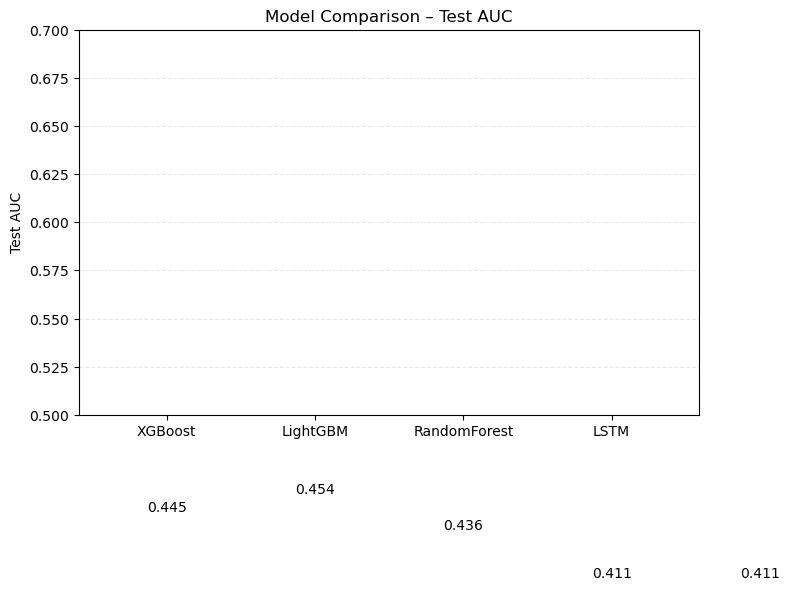

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(combined["Model"], combined["Test AUC"])
plt.ylabel("Test AUC")
plt.title("Model Comparison – Test AUC")
plt.ylim(0.5, 0.7)
for i, v in enumerate(combined["Test AUC"]):
    plt.text(i, v + 0.005, f"{v:.3f}", ha="center")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


Technical data shape : (79542, 56)
Sentiment data shape : (620, 132)
Unique tickers (tech): 42
Unique tickers (sent): 40

Tech date range : 2018-01-02 → 2025-11-24
Sent date range : 2025-01-07 → 2025-11-24

Per-ticker stats (first 10):


,ticker,tech_start,tech_end,tech_rows,tech_days,sent_start,sent_end,sent_rows,sent_days,coverage_ratio
0,AAPL,2018-01-02,2025-11-24,1986,2884.0,2025-11-14,2025-11-24,7.0,11.0,0.003814
1,AMD,2018-01-02,2025-11-24,1986,2884.0,2025-09-10,2025-11-24,39.0,76.0,0.026352
2,AMZN,2018-01-02,2025-11-24,1986,2884.0,2025-11-11,2025-11-24,8.0,14.0,0.004854
3,BA,2018-01-02,2025-11-24,1986,2884.0,2025-11-20,2025-11-24,4.0,5.0,0.001734
4,BAC,2018-01-02,2025-11-24,1986,2884.0,2025-11-20,2025-11-24,5.0,5.0,0.001734
5,BP,2018-01-02,2025-11-24,1986,2884.0,2025-11-18,2025-11-24,6.0,7.0,0.002427
6,CAT,2018-01-02,2025-11-24,1986,2884.0,2025-11-13,2025-11-24,8.0,12.0,0.004161
7,COST,2018-01-02,2025-11-24,1986,2884.0,2025-11-22,2025-11-24,3.0,3.0,0.001040
8,CRM,2018-01-02,2025-11-24,1986,2884.0,2025-10-31,2025-11-24,10.0,25.0,0.008669
9,CVX,2018-01-02,2025-11-24,1986,2884.0,2025-04-19,2025-11-24,40.0,220.0,0.076283



Summary statistics (tech_days, sent_days, coverage_ratio):


,tech_days,sent_days,coverage_ratio
count,41.00,40.00,40.00
mean,2815.76,74.12,0.03
std,436.97,99.66,0.03
min,86.00,2.00,0.00
25%,2884.00,5.00,0.00
50%,2884.00,13.00,0.00
75%,2884.00,125.25,0.04
max,2884.00,322.00,0.11



Tickers with sentiment history < 60 days:
26 out of 42 tickers

Tickers with coverage_ratio < 0.3:
40 out of 42 tickers


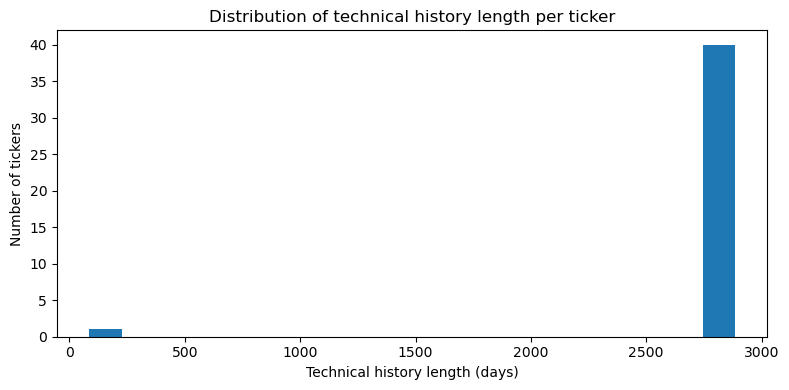

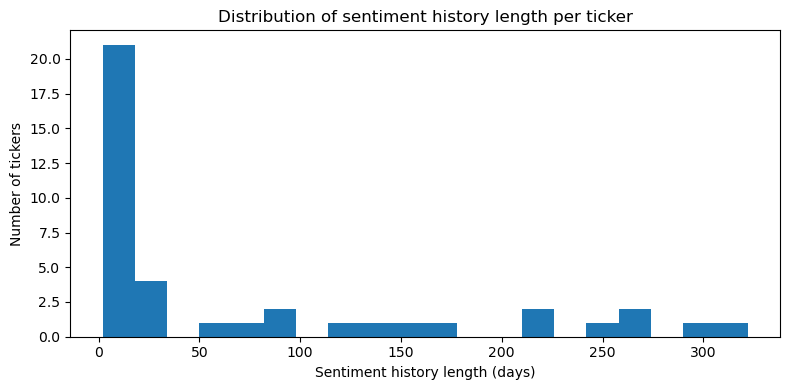

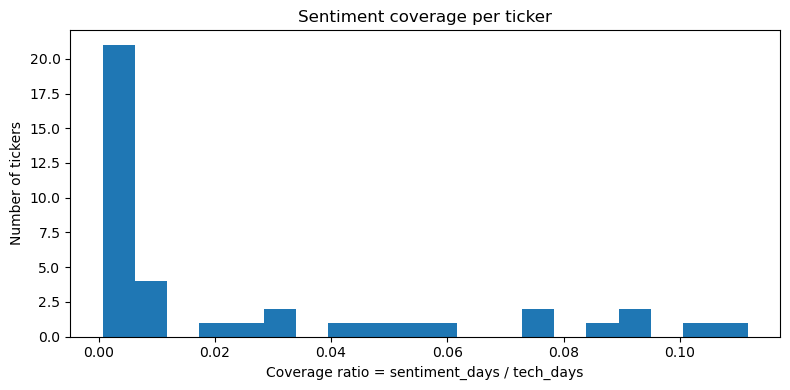


Lowest 5 tickers by sentiment coverage ratio:


,ticker,tech_days,sent_days,coverage_ratio
35,TGT,2884.0,2.0,0.000693
7,COST,2884.0,3.0,0.001040
15,IBM,2884.0,4.0,0.001387
33,SHOP,2884.0,5.0,0.001734
3,BA,2884.0,5.0,0.001734


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------------------------------------------
# 1. Load technical + sentiment datasets
# ---------------------------------------------------------
tech_path = Path("data/processed/merge_T_only_h5.csv")
sent_path = Path("data/processed/sentiment_features_enhanced.csv")

tech = pd.read_csv(tech_path, parse_dates=["date"])
sent = pd.read_csv(sent_path, parse_dates=["date"])

tech["ticker"] = tech["ticker"].astype(str).str.upper()
sent["ticker"] = sent["ticker"].astype(str).str.upper()

print("Technical data shape :", tech.shape)
print("Sentiment data shape :", sent.shape)
print("Unique tickers (tech):", tech["ticker"].nunique())
print("Unique tickers (sent):", sent["ticker"].nunique())
print()

print("Tech date range :", tech["date"].min().date(), "→", tech["date"].max().date())
print("Sent date range :", sent["date"].min().date(), "→", sent["date"].max().date())
print()

# ---------------------------------------------------------
# 2. Per-ticker history length for tech and sentiment
# ---------------------------------------------------------
tech_stats = (
    tech.groupby("ticker")["date"]
        .agg(tech_start="min", tech_end="max", tech_rows="count")
        .reset_index()
)
tech_stats["tech_days"] = (tech_stats["tech_end"] - tech_stats["tech_start"]).dt.days + 1

sent_stats = (
    sent.groupby("ticker")["date"]
        .agg(sent_start="min", sent_end="max", sent_rows="count")
        .reset_index()
)
sent_stats["sent_days"] = (sent_stats["sent_end"] - sent_stats["sent_start"]).dt.days + 1

# Merge both
stats = tech_stats.merge(sent_stats, on="ticker", how="left")

# Coverage ratio: how much of tech history has sentiment
stats["coverage_ratio"] = stats["sent_days"] / stats["tech_days"]

print("Per-ticker stats (first 10):")
display(stats.head(10))

print("\nSummary statistics (tech_days, sent_days, coverage_ratio):")
display(
    stats[["tech_days", "sent_days", "coverage_ratio"]].describe().round(2)
)

# How many tickers have *very short* sentiment history?
short_threshold = 60   # days
print(f"\nTickers with sentiment history < {short_threshold} days:")
print((stats["sent_days"] < short_threshold).sum(), "out of", len(stats), "tickers")

print("\nTickers with coverage_ratio < 0.3:")
print((stats["coverage_ratio"] < 0.3).sum(), "out of", len(stats), "tickers")

# ---------------------------------------------------------
# 3. Plots for the report
# ---------------------------------------------------------
plt.figure(figsize=(8,4))
plt.hist(stats["tech_days"], bins=20)
plt.xlabel("Technical history length (days)")
plt.ylabel("Number of tickers")
plt.title("Distribution of technical history length per ticker")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(stats["sent_days"].dropna(), bins=20)
plt.xlabel("Sentiment history length (days)")
plt.ylabel("Number of tickers")
plt.title("Distribution of sentiment history length per ticker")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(stats["coverage_ratio"].dropna(), bins=20)
plt.xlabel("Coverage ratio = sentiment_days / tech_days")
plt.ylabel("Number of tickers")
plt.title("Sentiment coverage per ticker")
plt.tight_layout()
plt.show()

# Optional: show the worst 5 tickers by coverage_ratio
print("\nLowest 5 tickers by sentiment coverage ratio:")
display(
    stats.sort_values("coverage_ratio").head(5)[
        ["ticker", "tech_days", "sent_days", "coverage_ratio"]
    ]
)


In [23]:
import pandas as pd

tech = pd.read_csv("data/processed/merge_T_only_h5.csv", parse_dates=["date"])
sent = pd.read_csv("data/processed/sentiment_features_enhanced.csv", parse_dates=["date"])

# Compute sentiment-days per ticker
sent_days = sent.groupby("ticker")["date"].nunique().sort_values()

print("Sentiment days per ticker:")
print(sent_days)

print("\nSummary:")
print(sent_days.describe())

print("\nTickers with < 20 sentiment days:")
print(sent_days[sent_days < 20])

print("\nTickers with 0 sentiment days in tech universe:")
print(set(tech["ticker"].unique()) - set(sent["ticker"].unique()))


Sentiment days per ticker:
ticker
TGT       2
IBM       3
COST      3
SHOP      4
SPY       4
NKE       4
BA        4
PEP       5
BAC       5
MS        5
DIS       5
WMT       5
GS        5
QCOM      5
KO        5
UPS       6
BP        6
AAPL      7
UNH       7
CAT       8
AMZN      8
MA        9
GOOGL     9
CRM      10
V        11
ORCL     13
MRK      14
JPM      14
DIA      16
NFLX     18
MSFT     22
NVDA     27
XOM      33
AMD      39
CVX      40
QQQ      45
META     45
PFE      46
TSLA     50
INTC     53
Name: date, dtype: int64

Summary:
count    40.000000
mean     15.500000
std      15.521697
min       2.000000
25%       5.000000
50%       8.000000
75%      19.000000
max      53.000000
Name: date, dtype: float64

Tickers with < 20 sentiment days:
ticker
TGT       2
IBM       3
COST      3
SHOP      4
SPY       4
NKE       4
BA        4
PEP       5
BAC       5
MS        5
DIS       5
WMT       5
GS        5
QCOM      5
KO        5
UPS       6
BP        6
AAPL      7
UNH       7
CA